In [1]:
import polars as pl
import json
from pathlib import Path
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import helper

In [2]:
def process_one_region(region):
    file_path = f'data/{region}.json'

    with open(file_path, 'r') as file:
        # Read in json data (one file for each region)
        data = json.load(file)
         
        # Convert json data to a list of dicts (to facilitate to conversion to a dataframe)
        records = [
            {
                'year': year,
                'named_storms': values[0],
                'named_storm_days': values[1],
                'hurricanes': values[2],
                'hurricane_days': values[3],
                'major_hurricanes': values[4],
                'major_hurricane_days': values[5],
                'ace': values[6],
            }
            for year, values in data.items()
        ]

        # Make a dataframe from the list-o-dicts
        df = (
            pl.DataFrame(records)
            .with_columns(
                # pl.lit(region).cast(pl.Categorical).alias('region'),
                pl.lit(region).alias('region'),
                pl.col('year').cast(pl.UInt16),
            )
        )

        # Put 'region" column first and scoot the rest to the right
        cols = df.columns
        cols = cols[-1:] + cols[:-1]

    return df[cols]

In [3]:
# Grab data from source .json files
data_dir = Path('data')
json_files = [file for file in data_dir.glob('*.json') if file.is_file()]

In [4]:
# Combine all region's pertinent data into one dataframe
master_df = pl.DataFrame()

for file in json_files:
    region = file.stem
    print(f'Processing the {region} region...')
    master_df = master_df.vstack(process_one_region(region))

# Grab only the data needed for the chart
chart_df = (
    master_df
    .filter(
        pl.col('year').is_between(1980, 2023),
        ~pl.col('region').is_in(['global', 'northernhemisphere', 'southernhemisphere'])
    )
    .select(['region', 'year', 'major_hurricanes'])
)

Processing the northeastpacific region...
Processing the southindian region...
Processing the northatlantic region...
Processing the southernhemisphere region...
Processing the southpacific region...
Processing the northindian region...
Processing the global region...
Processing the northernhemisphere region...
Processing the northwestpacific region...


### `matplotlib` chart

In [5]:
wide = chart_df.pivot(on='year', values='major_hurricanes')

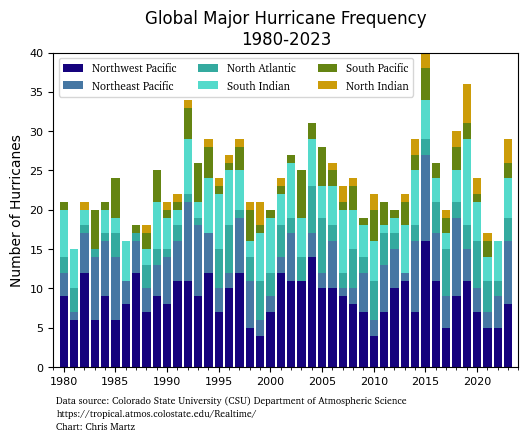

27

In [6]:
helper.make_chart(wide)

In [7]:
(
    chart_df
    .filter(pl.col('year') == 1980)
)

region,year,major_hurricanes
str,u16,i64
"""northeastpacific""",1980,3
"""southindian""",1980,6
"""northatlantic""",1980,2
"""southpacific""",1980,1
"""northindian""",1980,0
"""northwestpacific""",1980,9


### TODO
* add attribution footers

### Concerns

#### Concern: totals do not match
There are too many "close but not quite" values.

Could be due to source data files changing.  (Data from the web site is just a snapshot.)

#### Concern: consistent stack order
Chris' stack order is not consistent year after year.

When it exists, North Indian should be the top-most stack piece.

Yet 1990, 1992, 2006, 2013, and 2014 all show North Indian be the second top-most stack piece.


#### Concern: multiple stack pieces in the same year

eg, 1990 has two South Indian stack pieces.  So does 1992.

This raises concern about the aggregation of data.
